In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Week 5

* Train-test error curves
* Bias-variance estimation
* Sampling error via resampling
* Visualizing bias-variance tradeoff

## Generate a synthetic dataset 

- Generate random numbers with a seed 0 and std deviation 0.5, and reshape between -1 and 1.
- define y = 2 sinx + s
- For polynomial models of degrees 1,3,5,9 compute the train and test errors
- Plot!

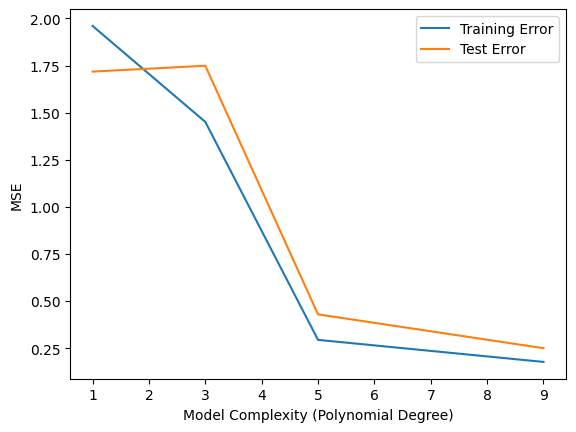

In [2]:
# Generate synthetic dataset
np.random.seed(1)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

n_dataset = X.size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

degrees = [1, 3, 5, 9]
train_errors = []
test_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.plot(degrees, train_errors, label="Training Error")
plt.plot(degrees, test_errors, label="Test Error")
plt.xlabel("Model Complexity (Polynomial Degree)")
plt.ylabel("MSE")
plt.legend()
plt.show()


### Exercise 1
Plot test and train errors vs size of dataset - modify the code above so that you can record test and train errors for a given model (say, polynomial of degree=5) for different sizes of the dataset (say, N=10,100,1000,10000). You may have to choose appropriate scaling for the X-axis.

N=   10 | Train MSE=0.0657 | Test MSE=16.7131
N=  100 | Train MSE=0.2807 | Test MSE=0.2207
N= 1000 | Train MSE=0.3571 | Test MSE=0.3888
N=10000 | Train MSE=0.3737 | Test MSE=0.3627


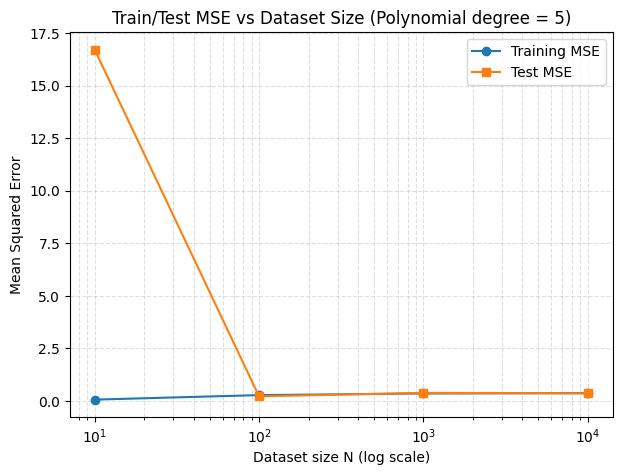

In [3]:


np.random.seed(1) 

def make_data(N, noise_std=0.5):
    X = np.linspace(0, 10, N).reshape(-1, 1)
    y = 2 * np.sin(X).ravel() + np.random.normal(0, noise_std, N)
    return X, y

degree = 5                           
sizes = [10, 100, 1000, 10000]       
train_mse_list = []
test_mse_list  = []

for N in sizes:
    X, y = make_data(N)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    poly = PolynomialFeatures(degree=degree)
    X_tr_poly = poly.fit_transform(X_train)
    X_te_poly = poly.transform(X_test)

    model = LinearRegression().fit(X_tr_poly, y_train)

    y_tr_pred = model.predict(X_tr_poly)
    y_te_pred = model.predict(X_te_poly)

    train_mse = mean_squared_error(y_train, y_tr_pred)
    test_mse  = mean_squared_error(y_test, y_te_pred)

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

    print(f"N={N:5d} | Train MSE={train_mse:.4f} | Test MSE={test_mse:.4f}")

plt.figure(figsize=(7,5))
plt.plot(sizes, train_mse_list, marker="o", label="Training MSE")
plt.plot(sizes, test_mse_list,  marker="s", label="Test MSE")
plt.xscale("log")
plt.xlabel("Dataset size N (log scale)")
plt.ylabel("Mean Squared Error")
plt.title(f"Train/Test MSE vs Dataset Size (Polynomial degree = {degree})")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


## Estimating Bias and Variance

In [4]:
from sklearn.utils import resample

def bias_variance_analysis(model, X, y, x_points, n_bootstrap=50):
    predictions = []
    for _ in range(n_bootstrap):
        X_samp, y_samp = resample(X, y)
        model.fit(X_samp, y_samp)
        predictions.append(model.predict(x_points))
    predictions = np.array(predictions)

    bias = (np.mean(predictions, axis=0) - y_true_points)**2
    variance = np.var(predictions, axis=0)
    return bias, variance

# Example at two points
x_points = np.array([[2], [7]])
y_true_points = 2 * np.sin(x_points).ravel()
model = LinearRegression()

bias, variance = bias_variance_analysis(model, X, y, x_points)
print("Bias:", bias)
print("Variance:", variance)


Bias: [1.82588974 1.00923332]
Variance: [0.00027626 0.00023691]


## Sampling error

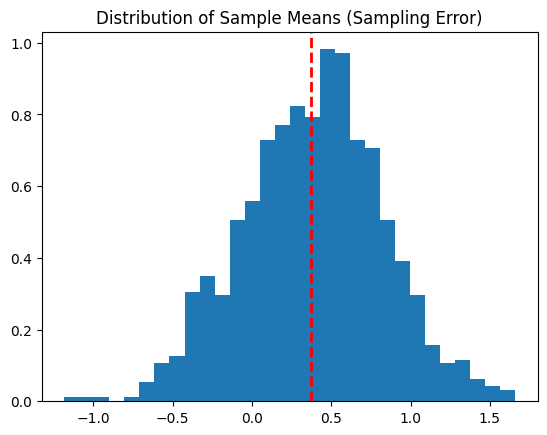

In [5]:
means = []
for _ in range(1000):
    sample = np.random.choice(y, size=10, replace=True)
    means.append(np.mean(sample))

plt.hist(means, bins=30, density=True)
plt.axvline(np.mean(y), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribution of Sample Means (Sampling Error)")
plt.show()


## Bias-variance tradeoff

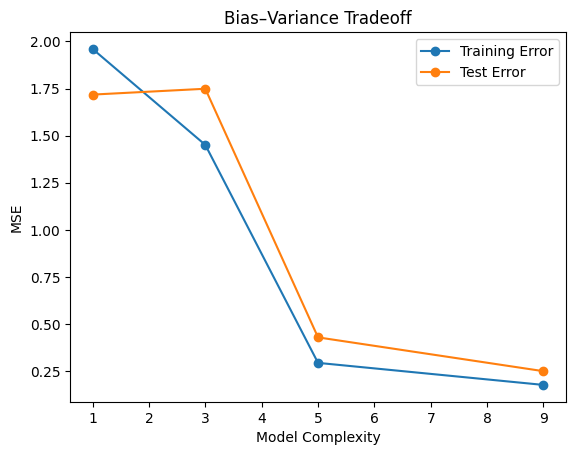

In [6]:
plt.plot(degrees, train_errors, 'o-', label="Training Error")
plt.plot(degrees, test_errors, 'o-', label="Test Error")
plt.title("Bias–Variance Tradeoff")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
plt.show()


## Bayes statistics demonstration

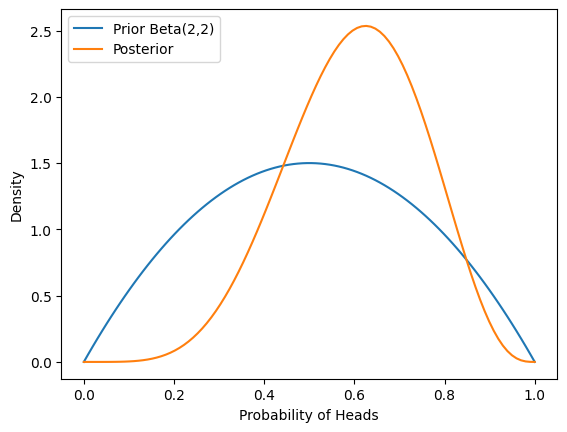

In [7]:
import scipy.stats as st

# Prior: Beta(2,2)
alpha_prior, beta_prior = 2, 2
data = [1,1,0,1,0,1]  # 1=head, 0=tail

# Posterior update
alpha_post = alpha_prior + sum(data)
beta_post = beta_prior + len(data) - sum(data)

x = np.linspace(0, 1, 100)
plt.plot(x, st.beta.pdf(x, alpha_prior, beta_prior), label="Prior Beta(2,2)")
plt.plot(x, st.beta.pdf(x, alpha_post, beta_post), label="Posterior")
plt.xlabel("Probability of Heads")
plt.ylabel("Density")
plt.legend()
plt.show()